<a href="https://colab.research.google.com/github/j3nguyen/user_item_embeddings/blob/master/NextAction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting User Journeys


Regardless of your business, being able to anticipate your users’ next action is a valuable advantage, whether that be a purchase, a view, or even a cancellation. Typical modelling approaches to predict users’ actions have focused on one specific action, e.g., conversion or churn. In this holistic approach, we model a users’ journey, so that we can not only anticipate a user’s next action but also the one after that.

There are many ways we can frame the problem. Here are four possible neural network architectures to solve the problem:

1.   Multi-class classification
2.   Fixed-length RNN
3. Variable-length RNN
4. Multi-step prediction RNN

Models 1 and 2 use a fixed number of historical actions to predict the next action, whereas Model 3 uses any number of previous actions to predict the next. Model 4 also uses a fixed number of previous actions but instead of predicting the next action, it predicts the next m actions.

All models are trained using the this e-commerce [data set](https://www.kaggle.com/retailrocket/ecommerce-dataset).



In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib
import pickle
import bz2

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Average, Dropout, Embedding, Activation, TimeDistributed, Concatenate, Flatten, Lambda, RepeatVector
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%run utils.py

## Data Preparation

Each model will require a different data preparation, but we will start by reading in the data.

In [0]:
df = pd.read_csv("events.csv")

#sort the dataframe by time
df.sort_values(by="timestamp", inplace=True)
df.head()

,timestamp,visitorid,event,itemid,transactionid
1462974,1430622004384,693516,addtocart,297662,NaN
1464806,1430622011289,829044,view,60987,NaN
1463000,1430622013048,652699,view,252860,NaN
1465287,1430622024154,1125936,view,33661,NaN
1462955,1430622026228,693516,view,297662,NaN


In [0]:
# get all the visitor_ids
visitor_ids = df.visitorid.unique()

print("There are {} users".format(len(visitor_ids)))

There are 1407580 users


In [0]:
# inspect action distribution
df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [0]:
# encode actions to numbers
action_to_idx = {"view": 0, "addtocart": 1, "transaction": 2}

#### User Activity

For models 1, 2 and 4 we want to rearrange the data so each row is one user and his/her sequence of actions.

In [0]:
visitor_activity = pickle.load(bz2.BZ2File('visitor_activity.pkl', 'r'))

In [0]:
# creating dictionary of visitor sequence of activity
visitor_activity = {}

for visitor in visitor_ids:
  # get user's actions in order of time
  actions = df[df.visitorid == visitor].event.values
  
  if len(actions) > 10:
    # get the first 51 actions
    actions = list(map(lambda x: action_to_idx[x],actions)) [:11] 
    visitor_activity[visitor] = actions

#### User sessions

For model 3, each row is a user session, where a new session starts after 30 minutes and each session has at least two actions so that we can use the last action as the target action to predict. This scenario most closely resembles user online activity.

The following code creates a dictionary of sessions for each user.

In [0]:
visitor_sessions = pickle.load(bz2.BZ2File('visitor_sessions.pkl', 'r'))

In [0]:
#30 mins in miliseconds 
session_expire = 60*30*1000

visitor_sessions = {}

for visitor in visitor_ids[:100000]:
    # calculate time deltas between actions
    time_delta = df[df.visitorid == visitor].timestamp.diff()
    actions = df[df.visitorid == visitor].event.values

    if len(actions) > 1:
      # split actions into sessions, where a session ends after session_expire
      all_sessions = np.split(actions,np.where(time_delta >= session_expire)[0])

      # sessions with more than one action
      filtered_sessions = list(filter(lambda x: len(x) > 1, all_sessions))

      if len(filtered_sessions) > 0:
        visitor_sessions[visitor] = list(map(lambda x: list(map(lambda y: action_to_idx[y],x)) ,filtered_sessions))


In [0]:
#visualize userflow using sankey chart
uf = pd.DataFrame(visitor_activity.values())

In [0]:
#format data to meet http://sankeymatic.com/build/ requirements
for i in range(5):
  # print("timestep %d" % i)
  for key, val in action_to_idx.items(): #FF9733, #3344FF, #FF3344
    for key2, val2 in action_to_idx.items():
      count = uf[(uf[i] == val) & (uf[i+1] == val2)].shape[0]
      if val2 == 0:
        print("%s_%d [%d] %s_%d #0FAFC0" % (key, i, count, key2, i+1))
      elif val2 == 1:
        print("%s_%d [%d] %s_%d #FF9733" % (key, i, count, key2, i+1))
      else:
        print("%s_%d [%d] %s_%d #C0160F" % (key, i, count, key2, i+1))
   

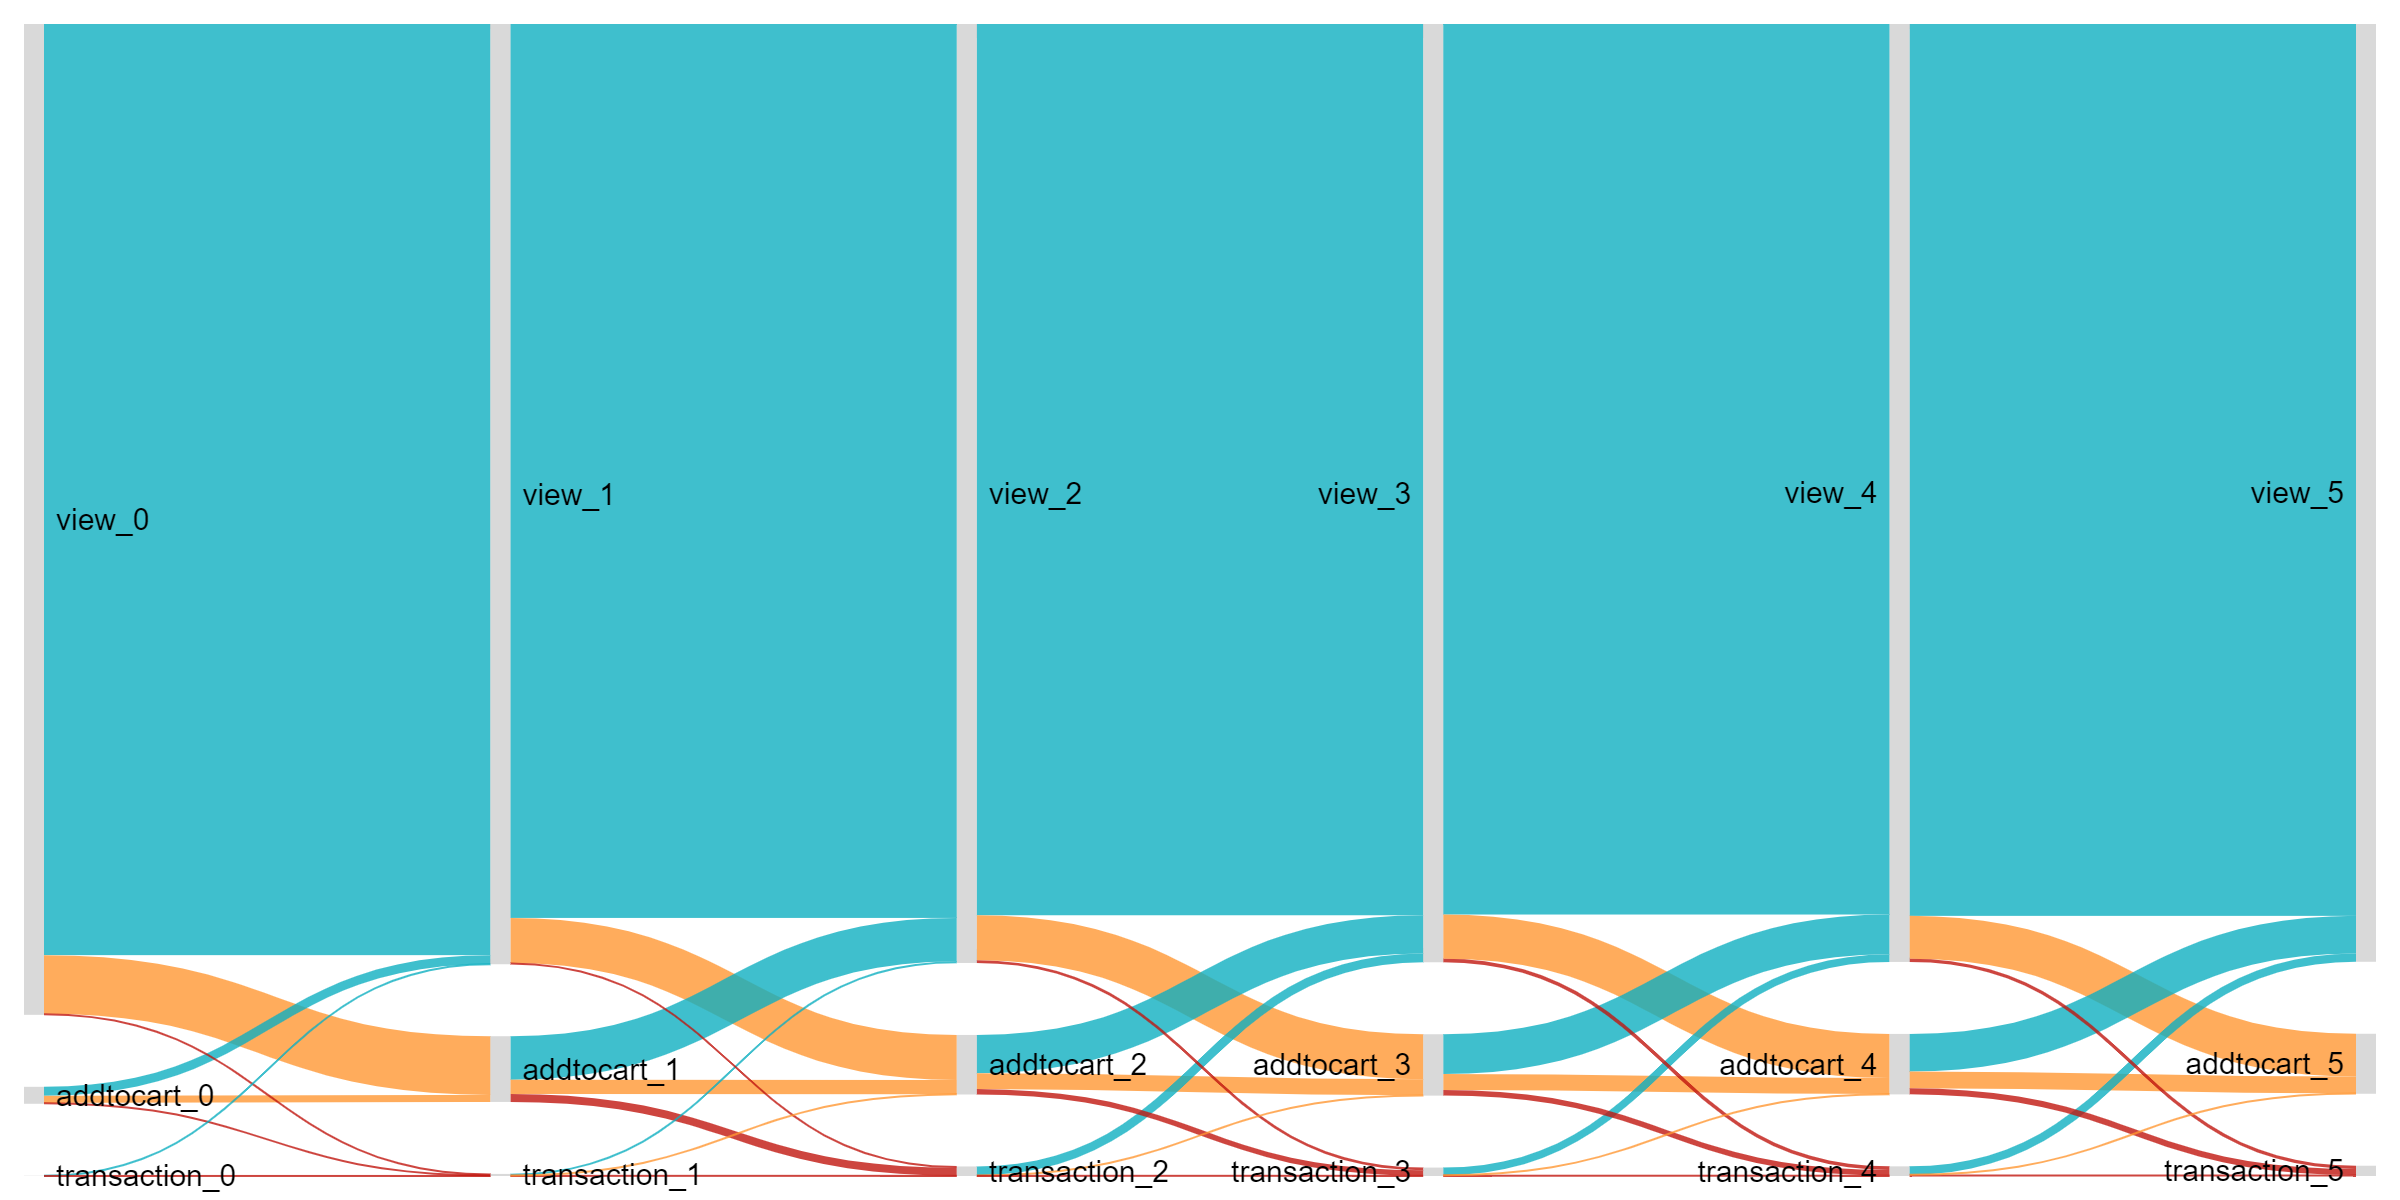

In [66]:
from IPython.display import Image, display
Image("sankeymatic.png", retina=True)

In [0]:
# pickle the visitor activity and visitor sessions to re-use next time
# pickle.dump( visitor_sessions, bz2.BZ2File('visitor_sessions.pkl', 'w') )
# pickle.dump(visitor_activity, bz2.BZ2File('visitor_activity.pkl','w'))

#### Create the training data and labels

Dataset 1: Here, we use the first n actions and predict the n+1 action as the label

In [0]:
actions = visitor_activity.values()
d = np.array(range(len(actions))) # users
X = np.array(list(map(lambda x: x[:-1], actions))) #actions for each user
y = to_categorical(np.array(list(map(lambda x: x[10], actions))), num_classes=3) # shift sequence one step forward

Dataset 2: We create samples of n actions and try to predict the next n actions

In [0]:
timesteps = 10
future_timesteps = 3

def generate_timeseries(actions, timesteps, lag, future_timesteps):
  '''
  timesteps - number of timesteps for input
  lag - the time difference between the input and output
  future_timesteps - number of timesteps for output
  '''
  ts = np.array(list(actions))
  X_ts = []
  y_ts = []

  for i in range(len(actions)):
    for j in range(0,len(ts[i])):
      x_start_idx = j
      x_end_idx = x_start_idx + timesteps

      y_start_idx = x_start_idx + lag 
      y_end_idx = y_start_idx + future_timesteps

      # print(x_start_idx, x_end_idx, y_start_idx, y_end_idx)
      #get a sequence of timesteps actions
      if y_end_idx <= len(ts[i]):
        x_input = ts[i,x_start_idx:x_end_idx]
        y_output = to_categorical(ts[i,y_start_idx:y_end_idx], num_classes=3)
        X_ts.append(x_input)
        y_ts.append(y_output)
    
  X_ts = np.array(X_ts)
  y_ts = np.array(y_ts)

  return X_ts, y_ts

X_ts, y_ts = generate_timeseries(actions, timesteps, timesteps, future_timesteps)
print(X_ts.shape)
print(y_ts.shape)

Dataset 3: Using the dictoinary of user sessions, we reformat the data to one session per row.

In [0]:
sessions = visitor_sessions.values()
sessions_flat = [item for sublist in sessions for item in sublist]

In [10]:
# assigning user_ids to each session
d_flat = [[i]*len(visitor_sessions[user_id]) for i, user_id in zip(range(len(sessions)),visitor_sessions.keys())]
d_flat = np.array([item for sublist in d_flat for item in sublist])

# using the last action as the label
X_sessions = np.array(list(map(lambda x: np.array(x[:-1]), sessions_flat)))
y_sessions = to_categorical(np.array(list(map(lambda x: x[-1], sessions_flat))),num_classes=3)
num_users_sessions = len(visitor_sessions)
print(X_sessions.shape)
print(y_sessions.shape)

(40000,)
(40000, 3)


Create training and test sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=342,stratify=y)

In [0]:
X_ts_train, X_ts_test, y_ts_train, y_ts_test = train_test_split(X_ts,y_ts, test_size = 0.2, random_state=342)

In [0]:
X_sessions_train, X_sessions_test,y_sessions_train, y_sessions_test = train_test_split(X_sessions,y_sessions, test_size = 0.2, random_state=342,stratify=y_sessions)

In [0]:
X_sessions_train, X_sessions_val,y_sessions_train, y_sessions_val = train_test_split(X_sessions_train,y_sessions_train, test_size = 0.2, random_state=342,stratify=y_sessions_train)

## Build the models

### Using the Keras functional API

We treat each user action like a word. In this data set, there are three types of actions:


* view
* add to cart
* transaction

Therefore, the size of the vocabulary is 3. A user's sequence of actions, or her journey, is liken to a sentence/paragraph.

We want to embed these actions into vectors to help predict the next action. 

#### Model 1: Multi-class classification
The first model will embed the actions and user's journey to help predict the next action. This is similar to a multi-class classification problem.

The code for this model is adapted from this [doc2vec implementation](https://bit.ly/2Q8sf1h)



In [0]:
hidden_size = 32 #dimension of action vectors
num_actions = len(action_to_idx) #dictionary size
input_length = 10 # number of actions in input sequence
num_users = len(visitor_activity)

In [15]:
#Create the NN using the functional API

def nn_model(input_length, num_units, num_actions, num_users=None):

  # Input sequence of actions
  A = Input(shape=(input_length,), name="actions") #length of sequence, size of vocab

  #create embedding for actions
  x = Embedding(input_dim=num_actions, output_dim=num_units, input_length=input_length, name='action_embedding')(A) # shape 50,64
  
  if num_users is not None:
    U = Input(shape=(1,), name="users")
    u = Embedding(input_dim=num_users, output_dim=num_units, input_length=1, name='user_embedding')(U) # shape 1,64
    
    # concatenate embeddings
    x = Concatenate(axis=1)([u,x])

  # create the hidden layers
  x = Dense(num_units, activation='relu')(x)

  if num_users is None:
    split = Lambda(my_split(input_length-1))(x)
  else:
    split = Lambda(my_split(input_length))(x)

  averaged = Average()(split)
  squeezed = Lambda(squeeze(axis=1))(averaged)

  predictions = Dense(num_actions, activation='softmax')(squeezed)

  if num_users is None:
    m = Model(inputs=A, outputs=predictions, name='Plain NN')
  else:
    m = Model(inputs=[U,A], outputs=predictions, name='Plain NN')

  return m

model = nn_model(input_length=10, num_units=hidden_size, num_actions=num_actions)
model.summary()
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)




Model: "Plain NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actions (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
action_embedding (Embedding)    (None, 10, 32)       96          actions[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10, 32)       1056        action_embedding[0][0]           
__________________________________________________________________________________________________
lambda_1 (Lambda)               [(None, 1, 32), (Non 0           dense_1[0][0]                    
________________________________________________________________________________________

In [0]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
h = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1, verbose=0,  class_weight={0:0.1, 1: 0.3, 2:0.6})

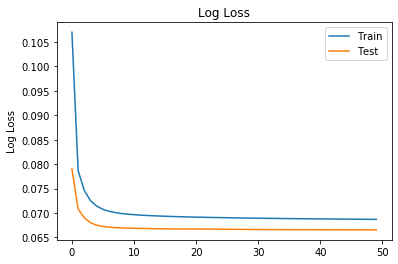

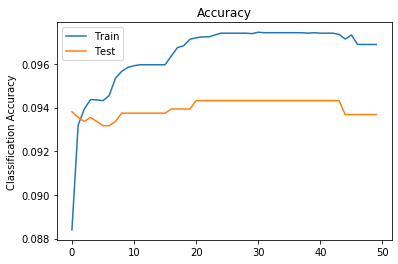

In [17]:
plot_learning_graphs(h.history)

#### Model 2: Fixed-length RNN
Next we build an RNN which will take into account the order of a user's actions to predict the next action.

Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
actions (InputLayer)         (None, 10)                0         
_________________________________________________________________
action_embedding (Embedding) (None, 10, 32)            96        
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 8,515
Trainable params: 8,515
Non-trainable params: 0
_________________________________________________________________


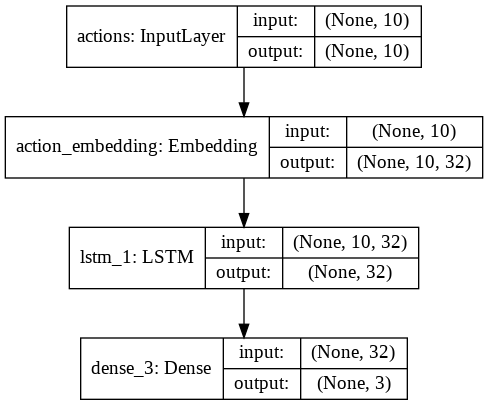

In [20]:
#Create the NN network using the functional API

def rnn_model(input_length, num_units, num_actions):
  # sequence of actions
  A = Input(shape=(input_length,), name="actions") #length of sequence

  #create embedding for actions
  a = Embedding(input_dim=num_actions, output_dim=num_units, name='action_embedding')(A) # shape 50,64

  #add LSTM Layer
  L = LSTM(num_units,return_sequences=False)(a)

  #add regular NN layer
  predictions = Dense(num_actions, activation='softmax')(L)

  return Model(inputs=A, outputs=predictions, name='RNN_model')

model2 = rnn_model(input_length, hidden_size, num_actions)
model2.summary()
plot_model(model2, show_shapes=True, show_layer_names=True)

In [0]:
# create the optimizer
opt2 = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

model2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])

In [0]:
h2 = model2.fit(X_train, y_train, epochs=50, batch_size=128, class_weight={0:0.1, 1: 0.3, 2:0.6}, validation_split=0.1, verbose=0)

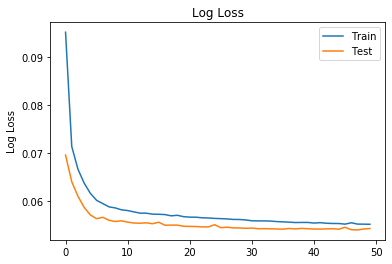

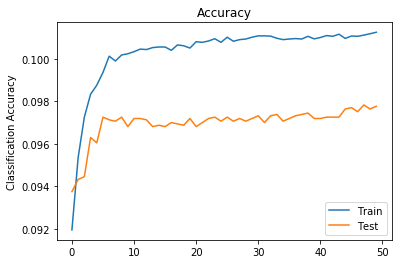

In [23]:
plot_learning_graphs(h2.history)

#### Model 3: Variable length RNN

Here, we use a user session, which can have a variable number of actions, to predict the next action. Popular techniques to create variable length RNNs include padding missing values or bucketing data instances into similar-sized batches. Here, we use the latter where each batch is a size of 1.

Model: "Variable_length_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
actions (InputLayer)         (None, None)              0         
_________________________________________________________________
action_embedding (Embedding) (None, None, 64)          192       
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 195       
Total params: 33,411
Trainable params: 33,411
Non-trainable params: 0
_________________________________________________________________


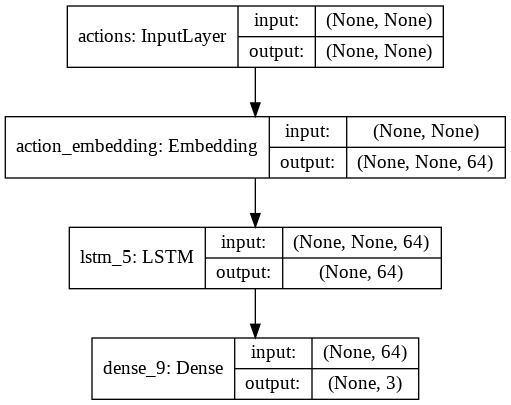

In [77]:

def var_rnn_model(num_units, num_actions):
  # sequence of actions
  A = Input(shape=(None,), name="actions") #input is None as we do not know input length in advance

  #create embedding for actions
  a = Embedding(input_dim=num_actions, output_dim=num_units, name='action_embedding')(A) # do not specify input length
  
  # Create LSTM layer
  # return sequences=False as we only want the last output of the RNN
  L = LSTM(num_units,return_sequences=False)(a)

  predictions = Dense(num_actions, activation='softmax')(L)

  return Model(inputs=A, outputs=predictions, name='Variable_length_RNN')

model3 = var_rnn_model(hidden_size, num_actions)
model3.summary()
plot_model(model3, show_shapes=True, show_layer_names=True)

In [0]:
# create the optimizer
opt3 = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, decay=0.01)

model3.compile(optimizer=opt3, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])

h3 = model3.fit_generator(MyBatchGenerator(X_sessions_train,y_sessions_train),
                          validation_data=MyBatchGenerator(X_sessions_val,y_sessions_val), 
                          class_weight={0:0.1, 1: 0.3, 2:0.6},
                          epochs=25, 
                          verbose=1)

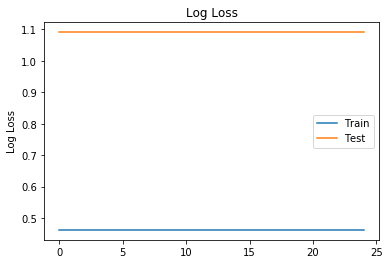

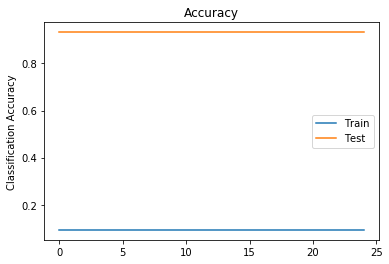

In [64]:
plot_learning_graphs(h3.history)

#### Model 4: Multi-step predictions

This model uses the first n actions to predict the next n actions by using an encoder-decoder architecture.




Model: "Multi-step Prediction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
actions (InputLayer)         (None, 10)                0         
_________________________________________________________________
action_embedding (Embedding) (None, 10, 64)            192       
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 3)              195       
Total params: 66,435
Trainable params: 66,435
Non-trainable params: 0
______________________________________

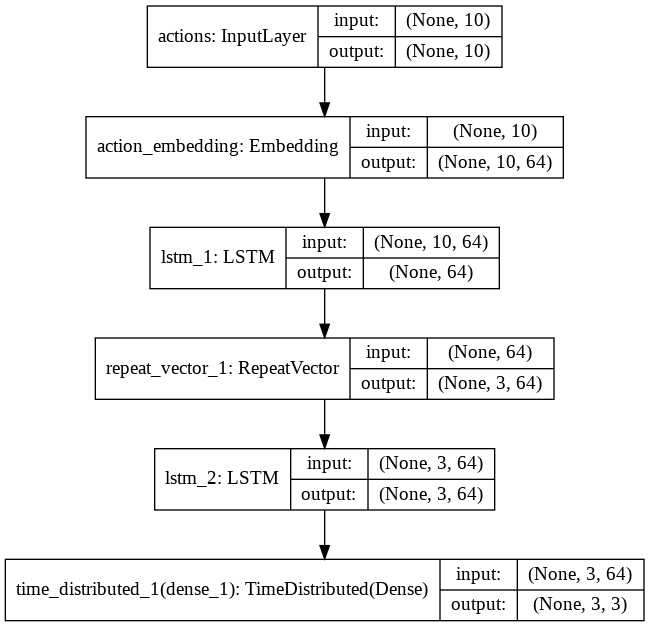

In [54]:
def multistep_rnn_model(input_length, forecast_length, num_units, num_actions):
  # sequence of actions
  A = Input(shape=(input_length,), name="actions") #length of sequence

  #create embedding for actions 
  a = Embedding(input_dim=num_actions, output_dim=num_units, input_length=input_length, name='action_embedding')(A) 

  # return_sequences = false to only produce the last output
  encoder = LSTM(num_units,return_sequences=False)(a)

  # repeat the output of the encoder for each output of the target
  temp = RepeatVector(forecast_length)(encoder)

  decoder = LSTM(num_units, return_sequences=True)(temp)

  # Apply a NN for each timestep output
  predictions = TimeDistributed(Dense(num_actions, activation='softmax'))(decoder)

  return Model(inputs=A, outputs=predictions, name="Multi-step Prediction")

model4 = multistep_rnn_model(timesteps, future_timesteps, hidden_size, num_actions)  
model4.summary()

plot_model(model4, show_shapes=True, show_layer_names=True)



In [0]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)

model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
h4 = model4.fit(X_ts_train, y_ts_train, epochs=50, batch_size=128, validation_split=0.1,  verbose=1)

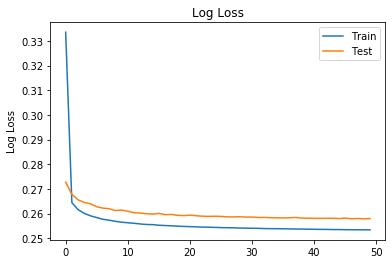

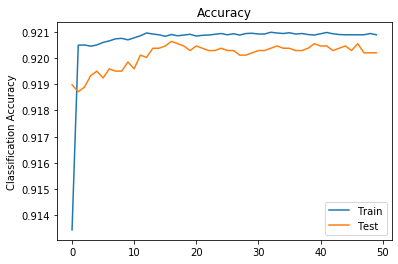

In [56]:
plot_learning_graphs(h4.history)

## Evaluate models

Let's see how our models perform

In [0]:
y_true = np.argmax(y_test,axis=1)

In [0]:
## Model 1 predictions
pred_prob = model.predict(X_test)
y_pred = np.argmax(pred_prob,axis=1)

In [0]:
## Model 2 predictions
pred_prob2 = model2.predict(X_test)
y_pred2 = np.argmax(pred_prob2,axis=1)

In [0]:
## Model 3 predictions
y_true_sessions = np.argmax(y_sessions_test,axis=1)

pred_prob3 = model3.predict_generator(MyBatchGenerator(X_sessions_test,y_sessions_test))
y_pred3 = np.argmax(pred_prob3,axis=1)

In [0]:
## Model 4 predictions
y_ts_test_labels = np.argmax(y_ts_test,axis=2)

pred_prob4 = model4.predict(X_ts_test)
y_pred4 = np.argmax(pred_prob4,axis=2)


Confusion matrix, without normalization
[[3518   62   44]
 [ 161   38    7]
 [  56    5   26]]


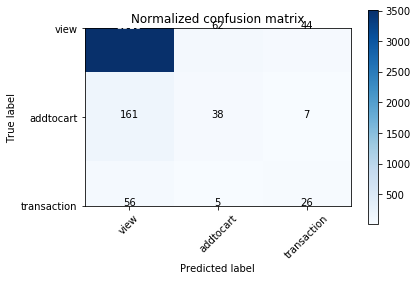

In [27]:
conf=confusion_matrix(y_true,y_pred)
plt.figure()
plot_confusion_matrix(conf, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

Confusion matrix, without normalization
[[3480   52   92]
 [ 137   46   23]
 [  24    5   58]]


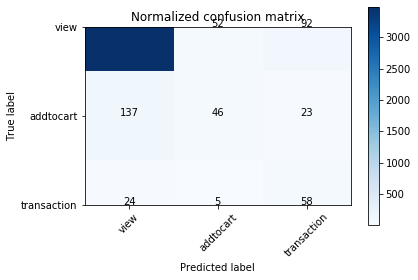

In [28]:
conf2=confusion_matrix(y_true,y_pred2)
plt.figure()
plot_confusion_matrix(conf2, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

In [0]:
conf3=confusion_matrix(y_true_sessions,y_pred3)
plt.figure()
plot_confusion_matrix(conf3, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

Confusion matrix, without normalization
[[26109   130     2]
 [ 1611   258     0]
 [  542     9     4]]


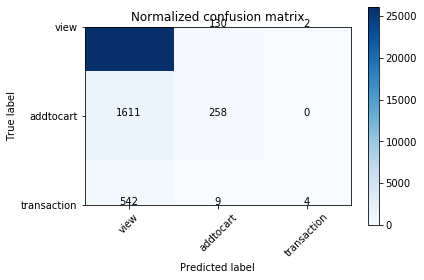

In [58]:
#new shape
num_instances = y_pred4.shape[0]*y_pred4.shape[1]

conf4=confusion_matrix(y_ts_test_labels.reshape((num_instances,)),y_pred4.reshape((num_instances,)))
plt.figure()
plot_confusion_matrix(conf4, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

In [29]:
print(classification_report(y_true,y_pred,target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.94      0.97      0.96      3624
   addtocart       0.36      0.18      0.24       206
 transaction       0.34      0.30      0.32        87

    accuracy                           0.91      3917
   macro avg       0.55      0.48      0.51      3917
weighted avg       0.90      0.91      0.90      3917



In [30]:
print(classification_report(y_true,y_pred2,target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.96      0.96      0.96      3624
   addtocart       0.45      0.22      0.30       206
 transaction       0.34      0.67      0.45        87

    accuracy                           0.91      3917
   macro avg       0.58      0.62      0.57      3917
weighted avg       0.92      0.91      0.91      3917



In [0]:
print(classification_report(y_true_sessions,y_pred3,target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.96      0.97      0.96      7459
   addtocart       0.39      0.06      0.11       318
 transaction       0.39      0.80      0.53       223

    accuracy                           0.93      8000
   macro avg       0.58      0.61      0.53      8000
weighted avg       0.92      0.93      0.92      8000



In [59]:
print(classification_report(y_ts_test_labels.reshape((num_instances,)),y_pred4.reshape((num_instances,)),target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.92      0.99      0.96     26241
   addtocart       0.65      0.14      0.23      1869
 transaction       0.67      0.01      0.01       555

    accuracy                           0.92     28665
   macro avg       0.75      0.38      0.40     28665
weighted avg       0.90      0.92      0.89     28665



For model 4, we also want to evaluate the predictions for each future time step.

In [24]:
def evaluate_predictions(true,predicted):
  scores = [None]*true.shape[1]

  for i in range(true.shape[1]):
    scores[i] = accuracy_score(true[:,i],predicted[:,i])
    print("LAG %d" % i)
    print(classification_report(true[:,i],predicted[:,i]))

  return scores

evaluate_predictions(y_ts_test_labels,y_pred4)

LAG 0
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      8739
           1       0.68      0.16      0.26       645
           2       0.50      0.01      0.02       171

    accuracy                           0.92      9555
   macro avg       0.70      0.39      0.41      9555
weighted avg       0.90      0.92      0.89      9555

LAG 1
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8750
           1       0.66      0.16      0.25       616
           2       0.33      0.01      0.01       189

    accuracy                           0.92      9555
   macro avg       0.64      0.39      0.41      9555
weighted avg       0.90      0.92      0.89      9555

LAG 2
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      8752
           1       0.59      0.13      0.22       608
           2       0.67      0.01      0.02       195

  

[0.9207744636316065, 0.9208791208791208, 0.9189952904238619]

## Use the model to predict

In [0]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread


User 5


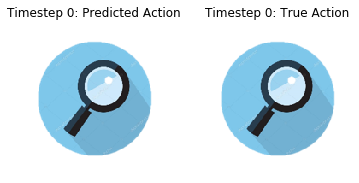

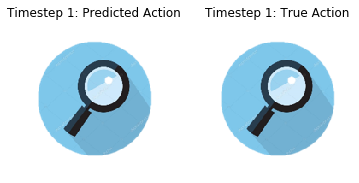

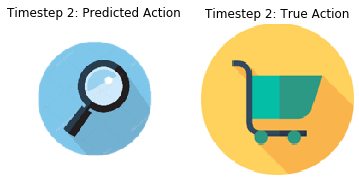

In [99]:
idx_to_action= {v:k for k,v in action_to_idx.items()}

i = 5
print("User %d" % i)
for j in range(future_timesteps):
  fig = figure()
  true_action = y_ts_test_labels[i,j]
  predicted_action = y_pred4[i,j]

  ax1 = fig.add_subplot(1,2,1)
  image = imread(idx_to_action[predicted_action] + ".png")
  imshow(image)
  ax1.title.set_text("Timestep %d: Predicted Action" % j)
  axis("off")
 
  ax2 = fig.add_subplot(1,2,2)
  image = imread(idx_to_action[true_action] + ".png")
  imshow(image)
  ax2.title.set_text("Timestep %d: True Action" % j)
  axis("off")

## user2Vec: embedding users

For fun, we can also embed users as well using a similar architecture as model 1. Note that this model would not work for new users as we wouldn't have any history for them. This is known as the cold-start or out of vocabulary problem.

In [0]:
user2vec_model = nn_model(input_length=input_length, num_units=hidden_size, num_actions=num_actions, num_users=num_users)
# user2vec_model.summary()
opt5 = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

user2vec_model.compile(optimizer=opt5, loss='categorical_crossentropy', metrics=['accuracy'])
h5 = user2vec_model.fit([d,X], y, epochs=50, batch_size=128, validation_split=0.1, verbose=0,  class_weight={0:0.1, 1: 0.3, 2:0.6})

After training the model, we can get the embeddings from the network and visualize it.

In [0]:
## embeddings for doc2vec model
embeddings = user2vec_model.get_layer(name='user_embedding')
embeddings = embeddings.get_weights()[0]
embeddings = embeddings / np.linalg.norm(embeddings, axis = 1).reshape((-1, 1))
embeddings = np.nan_to_num(embeddings)

### Use tSNE to visualize the embeddings

To visualize each user's vector, we reduce it to two dimensions using tSNE and colour code them with the 51st action

In [0]:
from sklearn.manifold import TSNE


In [0]:
y_labels = np.argmax(y,axis=1)

In [0]:
## Embeddings for doc2vec model
tsne = TSNE(n_components=2, init='pca', random_state=0)
embeddings_reduced = tsne.fit_transform(embeddings)

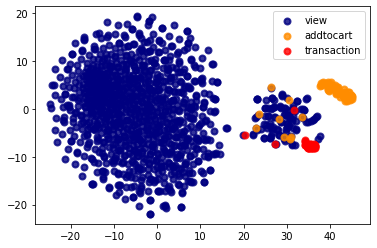

In [29]:
plt.figure()
colors = ['navy', 'darkorange', 'red']
lw = 2
target_names = action_to_idx.keys()

#original points
for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(embeddings_reduced[y_labels == i, 0], embeddings_reduced[y_labels == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.savefig("embedding.png")

We can see above that the NN did a good job of embedding users. The large cluster on the left are users who predominantly view items and a smaller cluster on the right with users who do add the viewed items to their shopping cart and/or checkout.

In [0]:
pickle.dump( embeddings3, bz2.BZ2File('embeddings3.pkl', 'w') )

## Conclusion

There are many different ways we can build a model to predict user journeys. Here we showed four different ways that only uses previous user actions. Other ideas we can try could be to include additional features into the model, e.g., the characteristics of the items being viewed.